# Анализ изменения цены услуг медицинской клиники

**Заказчик** — компания «Mains Lab»

**Цель Заказчика.** Выявление драйверов, определяющих изменение цены лечения

**Цель исследования.** Проверить гипотезы о влиянии различных факторов на среднюю стоимость обслуживания пациентов

**Задачи**
- Проверить гипотезу о влиянии изменения цен на услуги на среднюю стоимость обслуживания пациентов
- Проверить гипотезу о влиянии изменения интенсивности лечения пациентов на среднюю стоимость обслуживания пациентов
- Проверить гипотезу о влиянии изменения поло-возрастной структуры обслуживаемых пациентов на среднюю стоимость обслуживания пациентов
- Проверить гипотезу о влиянии изменения структуры оказываемых услуг на среднюю стоимость обслуживания пациентов
- Проверить гипотезу о влиянии изменения среднего количества оказанных услуг на один кейс на среднюю стоимость обслуживания пациентов
- Проверить гипотезу о влиянии изменения среднего количества посещений пациента на среднюю стоимость обслуживания пациентов

**Входные данные от Заказчика.** Файл в формате .xlsx со статистикой о посещении клиники.

**Определения**
- Медицинский кейс - последовательность медицинских услуг, полученных одним застрахованном в одной клинике с интервалом между любыми соседними по дате услугами не более 14 дней
- Визит - уникальное сочетание даты оказания услуги, застрахованного
- Обратившийся в месяц - уникальное сочетание месяца оказания услуги и идентификатора пациента

**Ожидаемый результат.** Выявлены факторы, влияющие на изменение средней стоимости лечения пациента

## Обзор данных

**Описание данных**

**Таблица `data_test_task_2022`**

- `record_id` - уникальный идентификатор строки данных
- `service_date` - дата оказания медицинской услуги
- `service_name` - наименование медицинской услуги
- `service_number` - количество услуг
- `service_amount` - сумма выплат (стоимость оказанных услуг в рублях)
- `insured` - уникальный идентификатор пациента
- `sex_id` - пол пациента
- `age_for_service_date` - возраст пациента

In [239]:
# Импотрт библиотек
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st
import datetime
import time

In [240]:
# Прочитаем файл
df = pd.read_excel('C:\\Users\\Aser\\Первый ноутбук\\Вакансии\\Задания\\MainLab\\data_test_task_2022.xls')
df.head()

,record_id,service_date,service_name,service_amount,service_number,insured,sex_id,age_for_service_date
0,30268157003,2021-01-24,Прием первичный,1470,1,490777,2.0,26
1,30268157103,2021-01-24,"Взятие материала на посев, цитологическое иссл...",284,1,490777,2.0,26
2,30268157203,2021-01-24,"Посев отдел, дыхательных путей - слизистая зев...",1134,1,490777,2.0,26
3,30268157303,2021-01-24,"Общий анализ крови (лейкоцитарная форм,, СОЭ)",693,1,490777,2.0,26
4,30268157403,2021-01-24,Ревматоидный фактор,420,1,490777,2.0,26


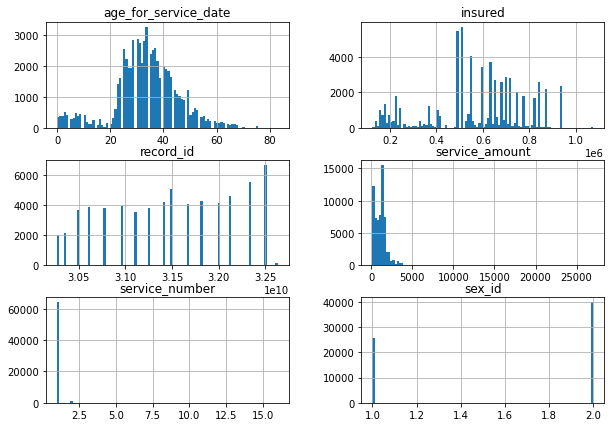

In [241]:
# Визуализируем данные
df.hist(bins=100, figsize=(10,7))
plt.show()

In [242]:
# Распределение посещений
df['service_number'].value_counts()

1     64245
2      1141
3       106
4        19
5        10
13        4
7         4
16        2
15        1
12        1
11        1
6         1
Name: service_number, dtype: int64

In [243]:
# Распределение выручки
df['service_amount'].value_counts()

1540     6127
1470     5415
1380     4416
1313     4025
170      1811
         ... 
3370        1
7720        1
2541        1
12810       1
1610        1
Name: service_amount, Length: 440, dtype: int64

In [244]:
# Проверим наличие пропусков
df.isna().sum()

record_id                0
service_date             0
service_name             0
service_amount           0
service_number           0
insured                  0
sex_id                  21
age_for_service_date     0
dtype: int64

In [245]:
# Выбросы выручки
df[df['service_amount']>5000].shape

(212, 8)

In [246]:
# Проверим наличие дубликатов
df.duplicated().sum()

0

In [247]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65535 entries, 0 to 65534
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   record_id             65535 non-null  int64  
 1   service_date          65535 non-null  object 
 2   service_name          65535 non-null  object 
 3   service_amount        65535 non-null  int64  
 4   service_number        65535 non-null  int64  
 5   insured               65535 non-null  int64  
 6   sex_id                65514 non-null  float64
 7   age_for_service_date  65535 non-null  int64  
dtypes: float64(1), int64(5), object(2)
memory usage: 3.5+ MB


In [248]:
# Проверим уникальность данных
print('Количество оказываемых услуг', len(df['service_name'].unique()))
print()
print('Перечень категорий пола', list(df['sex_id'].unique()))
print()
print('Количество уникальных пациентов', len(df['insured'].unique()))
print()
print('Дата начала исследования', df['service_date'].min())
print('Дата окончания исследования', df['service_date'].max())

Количество оказываемых услуг 798

Перечень категорий пола [2.0, 1.0, nan]

Количество уникальных пациентов 3555

Дата начала исследования 2021-01-03
Дата окончания исследования 2022-05-31


Датасет содержит 65535 строк и 8 столбцов

В столбце `sex_id` имеется 21 пропуск. Столбец `service_date` имеет тип `object`

По показателям количества услуг и сумма выплат есть выбросы. Для показателя количества выбросы обоснованы и на цену влиять не будут, а по показателю сумма выплат будут цену сдвигать вправо

Явных дублей нет. Список уникальных услуг содержит 798 позиций. Наблюдения проводились 18 месяцев - с 03.01.2021 по 31.05.2022.

**Предобработка данных**

- В столбце `service_date` установить тип `date`
- В столбце `sex_id` удалить пропуски
- Добавить столбец `price` с указанием цены услуги
- Добавить столбцы `year` `month` с указанием года и месяца соответственно
- Добавить столбец с `case` указанием номера медицинского кейса


## Предобработка данных

In [249]:
# Предобработка данных
df = df.dropna().reset_index(drop=True)
df['service_date'] = pd.to_datetime(df['service_date'], format='%Y-%m-%d')
df['price'] = df['service_amount'] / df['service_number']
df['month'] = df['service_date'].dt.month
df['year'] = df['service_date'].dt.year

**Разделение на кейсы**


In [250]:
# Функция преобразования разницы дат в число 
def delta(long):
    a = str(long)
    return int(a[:2])


In [251]:
# Выделим период между посещениями
df.sort_values(by = ['insured', 'service_date'])
df['long'] = df['service_date'] - df['service_date'].shift(fill_value=0)
df['long'] = df['long'].apply(delta)

# Разделим пациентов
df['chag_insured'] = df['insured'] - df['insured'].shift(fill_value=0)


C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Passing <class 'int'> to shift is deprecated and will raise in a future version, pass Timestamp instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [252]:
# Создание категорий / кейсов

#insured_list = list(df['insured'])
long_list = list(df['long'])
chag_insured_list = list(df['chag_insured'])
case_list = []
numb = 10000

for i in range(len(long_list)):
    if (long_list[i] <= 14) and (chag_insured_list[i] == 0):
        case_list.append(numb)
    else:
        numb += 1
        case_list.append(numb)

df['case'] = case_list


In [253]:
# Нормализация дней перерыва
def block(lon):
    if (lon<0) or (lon>14):
        return 0
    else:
        return lon

df['long'] = df['long'].apply(block)

In [254]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65514 entries, 0 to 65513
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   record_id             65514 non-null  int64         
 1   service_date          65514 non-null  datetime64[ns]
 2   service_name          65514 non-null  object        
 3   service_amount        65514 non-null  int64         
 4   service_number        65514 non-null  int64         
 5   insured               65514 non-null  int64         
 6   sex_id                65514 non-null  float64       
 7   age_for_service_date  65514 non-null  int64         
 8   price                 65514 non-null  float64       
 9   month                 65514 non-null  int64         
 10  year                  65514 non-null  int64         
 11  long                  65514 non-null  int64         
 12  chag_insured          65514 non-null  int64         
 13  case            

In [255]:
df.tail(10)

,record_id,service_date,service_name,service_amount,service_number,insured,sex_id,age_for_service_date,price,month,year,long,chag_insured,case
65504,32631202403,2022-05-11,Общий анализ мочи,450,1,744063,2.0,41,450.0,5,2022,0,0,20890
65505,32631202503,2022-05-11,"Прием гинеколога, первичный",1540,1,744063,2.0,41,1540.0,5,2022,0,0,20890
65506,32631202603,2022-05-11,Взятие мазка,360,1,744063,2.0,41,360.0,5,2022,0,0,20890
65507,32631202703,2022-05-11,Ультразвуковое исследование гинекология трансв...,2210,1,744063,2.0,41,2210.0,5,2022,0,0,20890
65508,32631202803,2022-05-11,"Исследование соскобов с поверхн, шейки матки",970,1,744063,2.0,41,970.0,5,2022,0,0,20890
65509,32631202903,2022-05-11,"Исследование соскобов с поверхн, цервикальног...",970,1,744063,2.0,41,970.0,5,2022,0,0,20890
65510,32631203003,2022-05-11,Гинекологический мазок,550,1,744063,2.0,41,550.0,5,2022,0,0,20890
65511,32631203103,2022-05-13,Ультразвуковое исследование сустава,1980,1,744063,2.0,41,1980.0,5,2022,2,0,20890
65512,32631203203,2022-05-13,"Прием травматолога-ортопеда, первичный",1540,1,744063,2.0,41,1540.0,5,2022,0,0,20890
65513,32631203303,2022-05-27,Фонофорез (1 сеанс) (1 поле),940,1,744063,2.0,41,940.0,5,2022,14,0,20890


**Группировка**


In [256]:
df_all = df.groupby(['case', 'year', 'sex_id', 'age_for_service_date']).agg({
    'service_amount': ['sum', 'count'],
    'price': 'mean',
    'long': 'sum',
    'service_number': 'sum'
})

# Изменим индексы
df_all.reset_index(inplace=True)

# Изменим названия столбцов
df_all.columns = ['case', 'year', 'sex', 'age', 'service_amount', 'count', 'price', 'long_all', 'service_sum']

# Добавим стоимость одного посещения в кейсе
df_all['amount_mean'] = df_all['service_amount'] / df_all['count']

In [257]:
df_all.head()

,case,year,sex,age,service_amount,count,price,long_all,service_sum,amount_mean
0,10001,2021,2.0,26,9705,12,808.750000,2,12,808.750000
1,10002,2021,2.0,25,4175,5,835.000000,1,5,835.000000
2,10003,2021,2.0,25,9163,12,763.583333,16,12,763.583333
3,10004,2021,1.0,40,15346,21,730.761905,0,21,730.761905
4,10005,2021,2.0,35,2426,2,1213.000000,0,2,1213.000000


## Анализ данных

In [258]:
df_all.corr()

,case,year,sex,age,service_amount,count,price,long_all,service_sum,amount_mean
case,1.000000,0.810698,-0.013432,0.033939,0.019740,-0.001885,0.025209,-0.003360,-0.002486,0.024183
year,0.810698,1.000000,-0.009411,0.027942,0.010446,-0.003103,0.019626,-0.005580,-0.003835,0.018841
sex,-0.013432,-0.009411,1.000000,0.044277,0.007877,0.013890,-0.022280,0.011657,0.021058,-0.013034
age,0.033939,0.027942,0.044277,1.000000,0.157073,0.152091,-0.015252,0.068640,0.154418,-0.000565
service_amount,0.019740,0.010446,0.007877,0.157073,1.000000,0.895433,0.063072,0.552152,0.896936,0.084225
count,-0.001885,-0.003103,0.013890,0.152091,0.895433,1.000000,-0.243856,0.514475,0.994114,-0.232053
price,0.025209,0.019626,-0.022280,-0.015252,0.063072,-0.243856,1.000000,-0.022413,-0.245715,0.976874
long_all,-0.003360,-0.005580,0.011657,0.068640,0.552152,0.514475,-0.022413,1.000000,0.511049,-0.020180
service_sum,-0.002486,-0.003835,0.021058,0.154418,0.896936,0.994114,-0.245715,0.511049,1.000000,-0.221823
amount_mean,0.024183,0.018841,-0.013034,-0.000565,0.084225,-0.232053,0.976874,-0.020180,-0.221823,1.000000


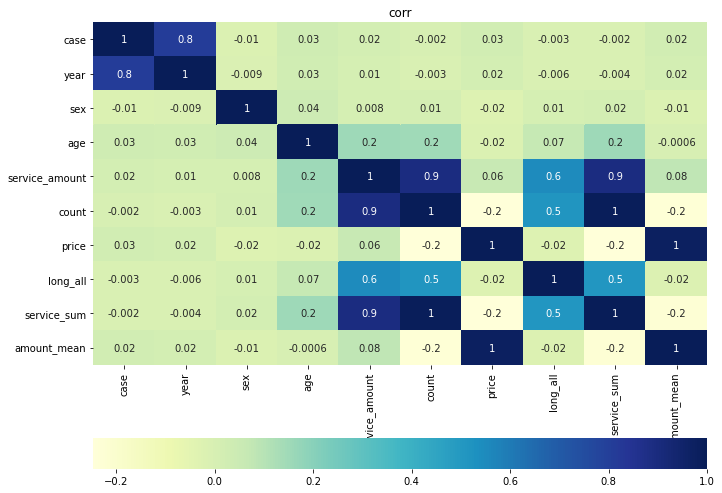

In [259]:
# Построим тепловую карту
plt.figure(figsize=(11, 9))
df_plot = sns.heatmap(df_all.corr(), cmap="YlGnBu", annot=True, fmt='.1g',
                     cbar_kws= {'orientation': 'horizontal'})
plt.title('corr')
plt.show()

In [260]:
# Напишем функцию для построенимя двойных гимтограмм 
def hist_pattern_dabl(df_1, df_2, bi, label, title):
    plt.figure(figsize=(7, 5))
    plt.hist([df_1, df_2], bins=bi, label=label)
    plt.legend()
    plt.title(title)
    return plt.show()

In [261]:
# Напишем функцию для визуализации проверки гипотез
def kdeplot_dabl(df_1, df_2, label, title):
    plt.figure(figsize=(7, 5))
    sns.kdeplot(data=df_1, label='2021')
    sns.kdeplot(data=df_2, label='2022')
    plt.xlabel(label)
    plt.title(title)
    plt.legend()
    return plt.show()

**Гипотеза об изменнеии сумм выплат в 2021 и 2022 гг.**

In [262]:
# Проверим гипотезу об изменнеии сумм выплат в 2021 и 2022 гг.
hip_0 = 'Нет ни какого различия между суммами выплат в 2021 и 2022 гг.'
hip_a = 'Существуют различия между суммами выплат в 2021 и 2022 гг.'

df_2021 = df.loc[df['year']==2021, 'service_amount']
df_2022 = df.loc[df['year']==2022, 'service_amount']

alpha = .05 # если p-value окажется меньше него - отвегнем нулевую гипотезу
results = st.ttest_ind(df_2021, df_2022, equal_var=False)
print('p-значение:', results.pvalue)

if results.pvalue > alpha:
    print('Принимаем нулевую гипотезу:', hip_0)
else:
    print('Ответгаем нулевую гипотезу:', hip_a)

p-значение: 2.6677361793543353e-07
Ответгаем нулевую гипотезу: Существуют различия между суммами выплат в 2021 и 2022 гг.


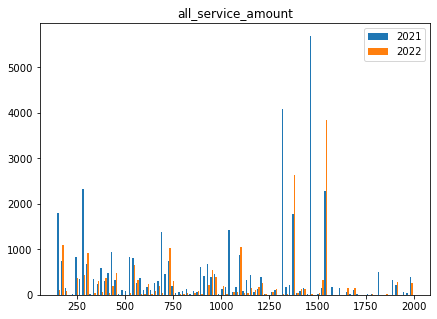

In [263]:
# Построим двойную гистограмму для сравнения сумм выплат в 2021 и 2022 гг
hist_pattern_dabl(df_2021[df_2021<2000],
                  df_2022[df_2022<2000], 
                  100, ['2021', '2022'], 'all_service_amount')

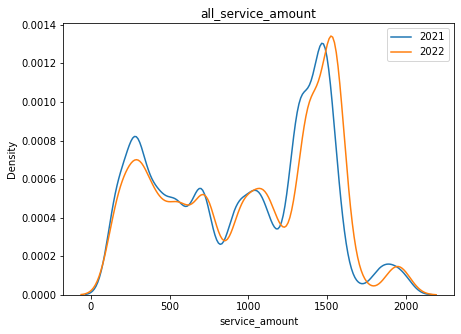

In [264]:
# Визуализируем проверку гипотезы о суммах выплат в 2021 и 2022 гг
kdeplot_dabl(df_2021[df_2021<2000], 
             df_2022[df_2022<2000],
             'service_amount', 'all_service_amount')

**Гипотеза об изменнеии суммы кейса в 2021 и 2022 гг.**

In [265]:
# Проверим гипотезу об изменнеии суммы кейса в 2021 и 2022 гг.
hip_c_0 = 'Нет ни какого различия между суммой кейса в 2021 и 2022 гг.'
hip_c_a = 'Существуют различия между суммой кейса в 2021 и 2022 гг.'

df_0_2021 = df_all.loc[df_all['year']==2021, 'service_amount']
df_0_2022 = df_all.loc[df_all['year']==2022, 'service_amount']

alpha = .05 # если p-value окажется меньше него - отвегнем нулевую гипотезу
results = st.ttest_ind(df_0_2021, df_0_2022, equal_var=False)
print('p-значение:', results.pvalue)

if results.pvalue > alpha:
    print('Принимаем нулевую гипотезу:', hip_c_0)
else:
    print('Ответгаем нулевую гипотезу:', hip_c_a)

p-значение: 0.2688551746557722
Принимаем нулевую гипотезу: Нет ни какого различия между суммой кейса в 2021 и 2022 гг.


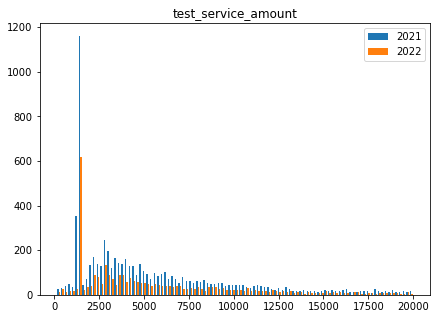

In [266]:
# Построим двойную гистограмму для сравнения суммы кейса в 2021 и 2022 гг
hist_pattern_dabl(df_0_2021[df_0_2021<20000],
                  df_0_2022[df_0_2022<20000], 
                  100, ['2021', '2022'], 'test_service_amount')

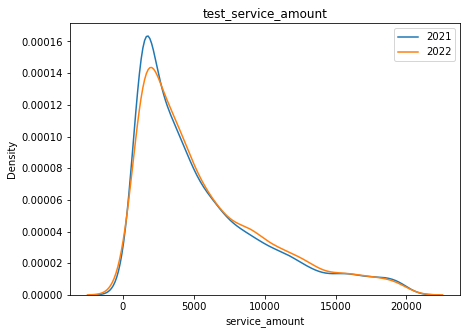

In [267]:
# Визуализируем проверку гипотезы о сумме кейсов в 2021 и 2022 гг
kdeplot_dabl(df_0_2021[df_0_2021<20000], 
             df_0_2022[df_0_2022<20000],
             'service_amount', 'test_service_amount')

## Проверка гипотез

**Гипотеза об изменнеии цен на услуги в 2021 и 2022 гг.**

In [268]:
# Проверим гипотезу об изменнеии цен на услуги в 2021 и 2022 гг.
hip_p_0 = 'Нет ни какого различия между ценами на услуги в 2021 и 2022 гг.'
hip_p_a = 'Существуют различия между ценами на услуги в 2021 и 2022 гг.'

df_1_2021 = df_all.loc[df_all['year']==2021, 'price']
df_1_2022 = df_all.loc[df_all['year']==2022, 'price']

alpha = .05 # если p-value окажется меньше него - отвегнем нулевую гипотезу
results = st.ttest_ind(df_1_2021, df_1_2022, equal_var=False)
print('p-значение:', results.pvalue)

if results.pvalue > alpha:
    print('Принимаем нулевую гипотезу:', hip_p_0)
else:
    print('Ответгаем нулевую гипотезу:', hip_p_a)

p-значение: 0.03307831322772047
Ответгаем нулевую гипотезу: Существуют различия между ценами на услуги в 2021 и 2022 гг.


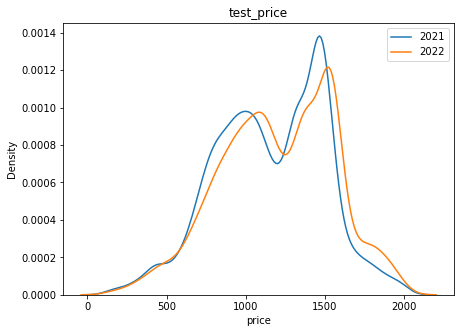

In [269]:
# Визуализируем проверку гипотезы о ценах на услуги в 2021 и 2022 гг
kdeplot_dabl(df_1_2021[df_1_2021<2000], 
             df_1_2022[df_1_2022<2000],
             'price', 'test_price')

**Гипотеза об изменнеии интенсивности лечения пациентов в 2021 и 2022 гг.**

In [270]:
# Проверим гипотезу об изменнеии интенсивности лечения пациентов  в 2021 и 2022 гг.
hip_l_0 = 'Нет ни какого различия между интенсивностью лечения пациентов в 2021 и 2022 гг.'
hip_l_a = 'Существуют различия между интенсивностью лечения пациентов в 2021 и 2022 гг.'

df_2_2021 = df_all.loc[df_all['year']==2021, 'long_all']
df_2_2022 = df_all.loc[df_all['year']==2022, 'long_all']

alpha = .05 # если p-value окажется меньше него - отвегнем нулевую гипотезу
results = st.ttest_ind(df_2_2021, df_2_2022, equal_var=False)
print('p-значение:', results.pvalue)

if results.pvalue > alpha:
    print('Принимаем нулевую гипотезу:', hip_l_0)
else:
    print('Ответгаем нулевую гипотезу:', hip_l_a)

p-значение: 0.5540920291695239
Принимаем нулевую гипотезу: Нет ни какого различия между интенсивностью лечения пациентов в 2021 и 2022 гг.


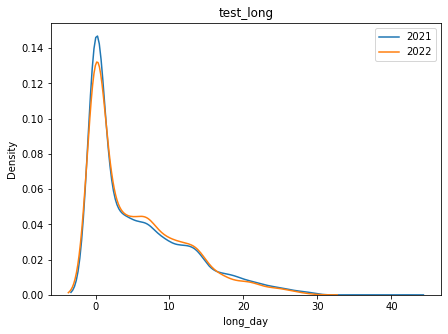

In [271]:
# Визуализируем проверку гипотезы об интенсивности лечения пациентов  в 2021 и 2022 гг
kdeplot_dabl(df_2_2021, df_2_2022,
             'long_day', 'test_long')

**Гипотеза о влиянии пола пациентов в 2021 и 2022 гг.**

In [272]:
# Проверим гипотезу о влиянии пола пациентов  в 2021 и 2022 гг.
hip_s_0 = 'Нет ни какого различия между полом пациентов в 2021 и 2022 гг.'
hip_s_a = 'Существуют различия между полом пациентов в 2021 и 2022 гг.'

df_3_1_2021 = df_all.loc[df_all['year']==2021, 'sex']
df_3_1_2022 = df_all.loc[df_all['year']==2022, 'sex']

alpha = .05 # если p-value окажется меньше него - отвегнем нулевую гипотезу
results = st.ttest_ind(df_3_1_2021, df_3_1_2022, equal_var=False)
print('p-значение:', results.pvalue)

if results.pvalue > alpha:
    print('Принимаем нулевую гипотезу:', hip_s_0)
else:
    print('Ответгаем нулевую гипотезу:', hip_s_a)

p-значение: 0.3268014941346108
Принимаем нулевую гипотезу: Нет ни какого различия между полом пациентов в 2021 и 2022 гг.


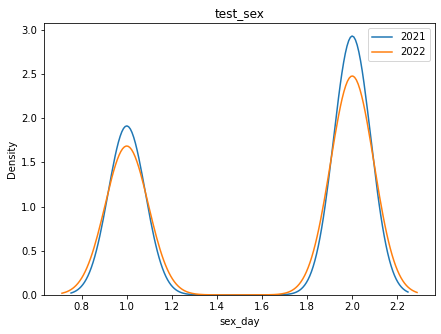

In [273]:
# Визуализируем проверку гипотезы о влиянии пола пациентов  в 2021 и 2022 гг
kdeplot_dabl(df_3_1_2021, df_3_1_2022,
             'sex_day', 'test_sex')

**Гипотеза об изменнеии возраста пациентов в 2021 и 2022 гг.**

In [274]:
# Проверим гипотезу о влиянии возраста пациентов  в 2021 и 2022 гг.
hip_a_0 = 'Нет ни какого различия между возрастом пациентов в 2021 и 2022 гг.'
hip_a_a = 'Существуют различия между возрастом пациентов в 2021 и 2022 гг.'

df_3_2_2021 = df_all.loc[df_all['year']==2021, 'age']
df_3_2_2022 = df_all.loc[df_all['year']==2022, 'age']

alpha = .05 # если p-value окажется меньше него - отвегнем нулевую гипотезу
results = st.ttest_ind(df_3_2_2021, df_3_2_2022, equal_var=False)
print('p-значение:', results.pvalue)

if results.pvalue > alpha:
    print('Принимаем нулевую гипотезу:', hip_a_0)
else:
    print('Ответгаем нулевую гипотезу:', hip_a_a)

p-значение: 0.002646452572277077
Ответгаем нулевую гипотезу: Существуют различия между возрастом пациентов в 2021 и 2022 гг.


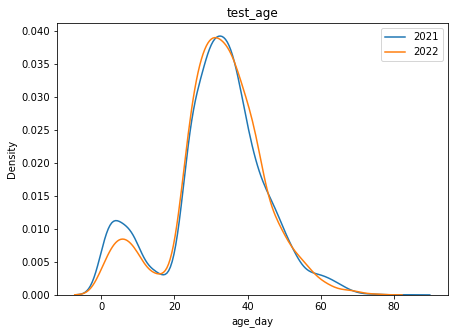

In [275]:
# Визуализируем проверку гипотезы о влиянии пола пациентов  в 2021 и 2022 гг
kdeplot_dabl(df_3_2_2021, df_3_2_2022,
             'age_day', 'test_age')

**Гипотеза об изменнеии структуры оказываемых услуг (больше/меньше дорогих) в 2021 и 2022 гг.**

In [276]:
# Проверим гипотезу о влиянии структуры оказываемых услуг в 2021 и 2022 гг.
hip_am_0 = 'Нет ни какого различия между структурой оказываемых услуг в 2021 и 2022 гг.'
hip_am_a = 'Существуют различия между структурой оказываемых услуг в 2021 и 2022 гг.'

df_4_2021 = df_all.loc[df_all['year']==2021, 'amount_mean']
df_4_2022 = df_all.loc[df_all['year']==2022, 'amount_mean']

alpha = .05 # если p-value окажется меньше него - отвегнем нулевую гипотезу
results = st.ttest_ind(df_4_2021, df_4_2022, equal_var=False)
print('p-значение:', results.pvalue)

if results.pvalue > alpha:
    print('Принимаем нулевую гипотезу:', hip_am_0)
else:
    print('Ответгаем нулевую гипотезу:', hip_am_a)

p-значение: 0.04147119783532366
Ответгаем нулевую гипотезу: Существуют различия между структурой оказываемых услуг в 2021 и 2022 гг.


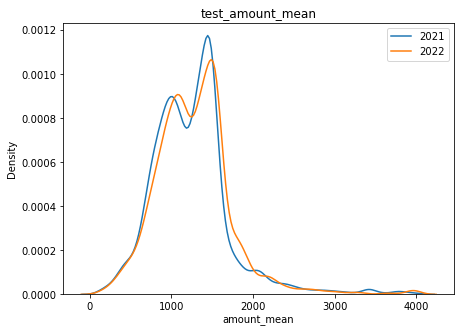

In [277]:
# Визуализируем проверку гипотезы о влиянии структуры оказываемых услуг в 2021 и 2022 гг
kdeplot_dabl(df_4_2021[df_4_2021<4000],
             df_4_2022[df_4_2022<4000],
             'amount_mean', 'test_amount_mean')

**Гипотеза об изменнеии среднего количества оказанных услуг на один кейс в 2021 и 2022 гг.**

In [278]:
# Проверим гипотезу о влиянии количества оказанных услуг в 2021 и 2022 гг.
hip_ss_0 = 'Нет ни какого различия между количеством оказываемых услуг в 2021 и 2022 гг.'
hip_ss_a = 'Существуют различия между количеством оказываемых услуг в 2021 и 2022 гг.'

df_5_2021 = df_all.loc[df_all['year']==2021, 'service_sum']
df_5_2022 = df_all.loc[df_all['year']==2022, 'service_sum']

alpha = .05 # если p-value окажется меньше него - отвегнем нулевую гипотезу
results = st.ttest_ind(df_5_2021, df_5_2022, equal_var=False)
print('p-значение:', results.pvalue)

if results.pvalue > alpha:
    print('Принимаем нулевую гипотезу:', hip_ss_0)
else:
    print('Ответгаем нулевую гипотезу:', hip_ss_a)

p-значение: 0.6833280263605552
Принимаем нулевую гипотезу: Нет ни какого различия между количеством оказываемых услуг в 2021 и 2022 гг.


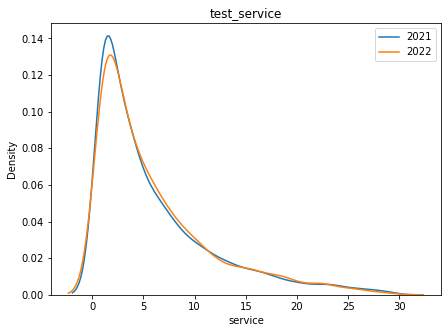

In [279]:
# Визуализируем проверку гипотезы о влиянии количества оказанных услуг в 2021 и 2022 гг
kdeplot_dabl(df_5_2021[df_5_2021<30], 
             df_5_2022[df_5_2022<30],
             'service', 'test_service')

**Гипотеза об изменнеии среднего количества посещений пациента в 2021 и 2022 гг.**

In [280]:
# Проверим гипотезу о влиянии количества посещений пациента в 2021 и 2022 гг.
hip_cp_0 = 'Нет ни какого различия между количеством посещений пациента в 2021 и 2022 гг.'
hip_cp_a = 'Существуют различия между количеством посещений пациента в 2021 и 2022 гг.'

df_6_2021 = df_all.loc[df_all['year']==2021, 'count']
df_6_2022 = df_all.loc[df_all['year']==2022, 'count']

alpha = .05 # если p-value окажется меньше него - отвегнем нулевую гипотезу
results = st.ttest_ind(df_6_2021, df_6_2022, equal_var=False)
print('p-значение:', results.pvalue)

if results.pvalue > alpha:
    print('Принимаем нулевую гипотезу:', hip_cp_0)
else:
    print('Ответгаем нулевую гипотезу:', hip_cp_a)

p-значение: 0.7416983336464134
Принимаем нулевую гипотезу: Нет ни какого различия между количеством посещений пациента в 2021 и 2022 гг.


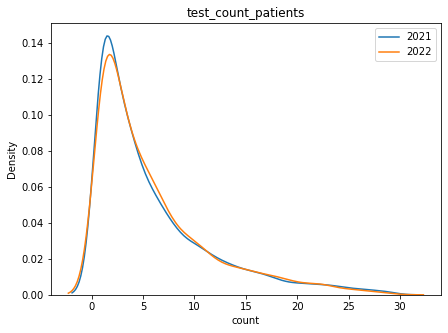

In [281]:
# Визуализируем проверку гипотезы о влиянии количества посещений пациента в 2021 и 2022 гг
kdeplot_dabl(df_6_2021[df_6_2021<30],
             df_6_2022[df_6_2022<30],
             'count', 'test_count_patients')

## Выводы


В ходе исследования были проанализированы показатели в рамках стандартного кейса. Для этого, в полученном датасете был выделена новая сущность – кейс, в соответствии с определением, предложенным заказчиком.

Изначальная гипотеза о том, что в 2022 году изменились суммы выплат относительно 2021 года подтвердилась. Однако, гипотеза о изменении суммы кейса – не подтвердилась. Т.о., на фоне общего изменения сумм выплат стоимость кейсов, в целом, не менялась.

Были исследованы следующие факторы, оказывающие влияние на суммы медицинских кейсов:
- изменение цен на услуги
- изменение интенсивности лечения пациентов
- изменение поло-возрастной структуры обслуживаемых пациентов
- изменение структуры оказываемых услуг 
- изменение среднего количества оказанных услуг на один кейс
- изменение среднего количества посещений пациента

Анализ указанных гипотез показал, что в 2022 году относительно 2021 произошли изменения по следующим факторам:
- изменение цен на услуги
- изменение возрастной структуры обслуживаемых пациентов
- изменение структуры оказываемых услуг 

В тоже время, корреляционный анализ показал, что между суммой кейса и иными показателями нет выраженной зависимости. Следовательно, можно говорить, что указанные выше факторы менялись в тоже время, когда менялись суммы выплат. Однако, нет четкого подтверждения о том, что эти изменения имели причинно-следственную связь.

**Резюме.** В ходе исследования не удалось выявить факторы, влияющие на изменение средней стоимости обслуживания пациентов. В тоже время, на фоне изменения сумм выплат были зафиксированы изменения цен на услуги, возрастной структуры пациентов и структуры оказываемых услуг, что может свидетельствовать о косвенном влиянии этих факторов.
